# Bag-of-Words Modeling: Kenya Focus

This notebook uses preprocessed .csv files from the Kiva Max Approver project, and uses word frequency analysis to attempt to predict loan funding status, with a focus on loans in Kenya. 

In [5]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#nlp
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction import text

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [6]:
# #downloads
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rachelinsler/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rachelinsler/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
# read in kenya data

kiva = pd.read_csv('data/kenya_pre_processed_nlp.csv').drop(columns='Unnamed: 0').set_index('LOAN_ID')

In [13]:
kiva.head()

,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS,STATUS
LOAN_ID,,,,
1799331,"['dinnah', '43', 'years', 'age', 'proud', 'mot...","['buy', 'farm', 'inputs', 'seeds', 'fertilizer...",['parent'],1
1294719,"['resy', 'married', 'woman', 'blessed', 'kids'...","['purchase', 'chicks', 'poultry', 'feed']","['animals', 'womanowned', 'business', 'volunte...",1
1595847,"['lavenda', 'happily', 'married', 'blessed', '...","['add', 'stock', 'beauty', 'products', 'salon']","['user_favorite', 'parent', 'womanowned', 'bus...",0
1139606,"['hadija', 'kiva', 'borrower', 'describes', 'h...","['buy', 'stock', 'vegetables', 'flour', 'sugar...","['repeat', 'borrower', 'womanowned', 'business']",1
1813411,"['purity', 'aged', '28', 'lovely', 'mother', '...","['purchase', 'highquality', 'seeds', 'nutrient...",['nan'],1


In [14]:
kiva.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50689 entries, 1799331 to 1767038
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DESCRIPTION_TRANSLATED  50689 non-null  object
 1   LOAN_USE                50689 non-null  object
 2   TAGS                    50689 non-null  object
 3   STATUS                  50689 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


In [15]:
kiva['STATUS'].value_counts()

1    39671
0    11018
Name: STATUS, dtype: int64

In [16]:
kiva['STATUS'].value_counts(normalize=True)

1    0.782635
0    0.217365
Name: STATUS, dtype: float64

## Model Description_Translated Column

#### Lemmatize for Bag of Words Model

In [17]:
lemmatizer = WordNetLemmatizer()

In [18]:
kiva['DESCRIPTION_TRANSLATED']  = kiva['DESCRIPTION_TRANSLATED'].apply(lambda x: lemmatizer.lemmatize(x))

#### Model

In [19]:
#set up X and y

X = kiva['DESCRIPTION_TRANSLATED']
y = kiva['STATUS']

In [20]:
#check for baseline
y.value_counts(normalize=True)

1    0.782635
0    0.217365
Name: STATUS, dtype: float64

In [21]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 stratify=y,
                                                 random_state=42)

#### Check Out Top Occuring Words with Count Vectorizer

In [22]:
cvec = CountVectorizer()

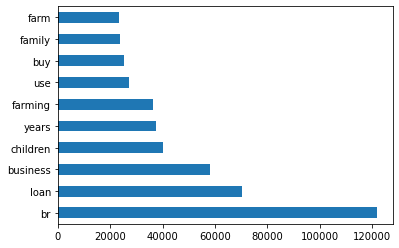

In [23]:
# convert training data to dataframe
X_train_df_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(),
                         columns=cvec.get_feature_names())


# plot top occurring words
X_train_df_cvec.sum().sort_values(ascending = False).head(10).plot(kind='barh');

In [60]:
## add in some stopwords - code inspired by varun
my_stop = ['br', 'nan']
stop_words = my_stop

### Run Through Classifiers

In [25]:
#create a list of the model classes to test
model_list = [
    LogisticRegression(),
    GradientBoostingClassifier(),
    RandomForestClassifier()
]

#### CVEC

In [26]:
#vectorize features with ngram range 1,3
cvec = CountVectorizer(stop_words=stop_words, max_features = 1_000, max_df=.98, min_df = 2, ngram_range =(1, 3))
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_cvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_cvec, y_train)
    results_dict['test_score'] = model.score(X_test_cvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_cvec, y_train, cv = 3).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

#create a dataframe and display dictionary
desc_results = pd.DataFrame(classifier_list)
desc_results

/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

,model_name,train_score,test_score,cv_score
0,LogisticRegression(),0.810905,0.799862,0.800079
1,GradientBoostingClassifier(),0.806491,0.803018,0.801879
2,RandomForestClassifier(),0.998249,0.798185,0.794999


Null Model is: 0.782635.

#### TVEC

In [27]:
#vectorize features with TF-IDF
tvec = TfidfVectorizer()
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_tvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_tvec, y_train)
    results_dict['test_score'] = model.score(X_test_tvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_tvec, y_train, cv = 3).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

#create a dataframe and display dictionary
desc_tvec_results = pd.DataFrame(classifier_list)
desc_tvec_results

/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

,model_name,train_score,test_score,cv_score
0,LogisticRegression(),0.832261,0.813080,0.810288
1,GradientBoostingClassifier(),0.813963,0.804399,0.807403
2,RandomForestClassifier(),0.999877,0.797495,0.798205


## Model LOAN_USE


#### Lemmatize for Bag of Words Model

In [28]:
#instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

In [29]:
#lemmatize LOAN_USE column
kiva['LOAN_USE']  = kiva['LOAN_USE'].apply(lambda x: lemmatizer.lemmatize(x))

In [30]:
#set up X and y

X = kiva['LOAN_USE']
y = kiva['STATUS']

In [31]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 stratify=y,
                                                 random_state=42)

### Check Out Top Occurring Words With CountVectorizer


In [32]:
cvec = CountVectorizer()

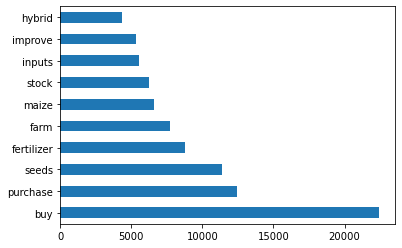

In [33]:
# convert training data to dataframe
X_train_df_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(),
                         columns=cvec.get_feature_names())


# plot top occurring words
X_train_df_cvec.sum().sort_values(ascending = False).head(10).plot(kind='barh');

### Run Through the Classifiers

#### CVEC

In [34]:
#vectorize features
cvec = CountVectorizer(stop_words=stop_words, max_features = 1_000, max_df=.98, min_df = 2, ngram_range =(1, 3))
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_cvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_cvec, y_train)
    results_dict['test_score'] = model.score(X_test_cvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_cvec, y_train, cv = 3).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

#create a dataframe and display dictionary
loan_use_results = pd.DataFrame(classifier_list)
loan_use_results

/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

,model_name,train_score,test_score,cv_score
0,LogisticRegression(),0.792064,0.790688,0.785480
1,GradientBoostingClassifier(),0.789894,0.786250,0.786392
2,RandomForestClassifier(),0.887870,0.770468,0.767700


#### TVEC

In [35]:
#vectorize features with TF-IDF
tvec = TfidfVectorizer()
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_tvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_tvec, y_train)
    results_dict['test_score'] = model.score(X_test_tvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_tvec, y_train, cv = 3).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

#create a dataframe and display dictionary
loan_use_tvec_results = pd.DataFrame(classifier_list)
loan_use_tvec_results

/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rachelinsler/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

,model_name,train_score,test_score,cv_score
0,LogisticRegression(),0.795591,0.789110,0.788784
1,GradientBoostingClassifier(),0.791818,0.789505,0.786491
2,RandomForestClassifier(),0.902468,0.778655,0.775887


# Interpretation and Next Steps

*  The LOAN_USE column does not appear to be predictive. 

*  For the 'DESCRIPTION_TRANSLATED' column, the logistic regression model with TVEC produced a slight improvement over the null model, without dramatic overfitting like RF. 
     *  Next steps are to tune this model. 

### Logistic Regression with TVEC

In [40]:
#set up X and y

X = kiva['DESCRIPTION_TRANSLATED']
y = kiva['STATUS']

In [41]:
#check for baseline
y.value_counts(normalize=True)

1    0.782635
0    0.217365
Name: STATUS, dtype: float64

In [42]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 stratify=y,
                                                 random_state=42)

In [43]:
#vectorize features with TF-IDF
tvec = TfidfVectorizer()
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [46]:
logreg = LogisticRegression(solver='liblinear', max_iter=800)
logreg.fit(X_train_tvec, y_train)
print(logreg.score(X_train_tvec,y_train), logreg.score(X_test_tvec,y_test))

0.8320633276614633 0.8126849477214441


In [49]:
#explore words and their coefficients 
coef_dict = {'coefficient': logreg.coef_[0], 'words': tvec.get_feature_names()}
coef_df = pd.DataFrame(coef_dict)
coef_df.sort_values(by = 'coefficient', ascending=False, inplace=True)

In [50]:
coef_df

,coefficient,words
264,9.313969,20000
448,5.485393,30000
26022,3.693703,widow
22762,3.525157,single
10002,3.391801,grew
...,...,...
14635,-3.546532,man
834,-4.400946,80000
85,-4.553032,120000
140,-4.692798,150000


In [78]:
#remove numbers from column
kiva['DESCRIPTION_TRANSLATED'] = kiva['DESCRIPTION_TRANSLATED'].str.replace('\d+', '')
kiva['DESCRIPTION_TRANSLATED'] = kiva['DESCRIPTION_TRANSLATED'].str.replace('trainingbr', 'training')

<ipython-input-78-88e79c778b65>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  kiva['DESCRIPTION_TRANSLATED'] = kiva['DESCRIPTION_TRANSLATED'].str.replace('\d+', '')


In [79]:
#set up X and y

X = kiva['DESCRIPTION_TRANSLATED']
y = kiva['STATUS']

In [80]:
#check for baseline
y.value_counts(normalize=True)

1    0.782635
0    0.217365
Name: STATUS, dtype: float64

In [81]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 stratify=y,
                                                 random_state=42)

In [82]:
## update stopwords
my_stop = ['br', 'nan','rnrnhe']
stop_words = my_stop

In [83]:
#vectorize features with TF-IDF
tvec = TfidfVectorizer(stop_words=stop_words)
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [84]:
logreg = LogisticRegression(solver='liblinear', max_iter=800)
logreg.fit(X_train_tvec, y_train)
print(logreg.score(X_train_tvec,y_train), logreg.score(X_test_tvec,y_test))

0.8204483243323223 0.8064707042809233


In [85]:
#explore words and their coefficients 
coef_dict = {'coefficient': logreg.coef_[0], 'words': tvec.get_feature_names()}
coef_df = pd.DataFrame(coef_dict)
coef_df.sort_values(by = 'coefficient', ascending=False, inplace=True, key = abs)

In [86]:
coef_df.head(25)

,coefficient,words
13641,-3.817638,man
25041,3.596605,widow
21782,3.301123,single
9080,3.163030,grew
16303,3.033246,north
25043,2.907011,widowed
24801,2.598028,water
8267,-2.573642,fourth
13167,-2.513684,loans
21577,-2.500201,shop
